In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
set_matplotlib_formats('svg')

In [3]:
title = pd.read_csv('data/soc-redditHyperlinks-title.tsv', delimiter = '\t')
body = pd.read_csv('data/soc-redditHyperlinks-body.tsv', delimiter = '\t')

T = title
B = body

# dataframe with both data sets
hyperlinks = pd.concat([title, body])
HL = hyperlinks

print(T.shape, B.shape, HL.shape)

(571927, 6) (286561, 6) (858488, 6)


In [4]:
# split into negative and positive edges
neg_mask = HL['LINK_SENTIMENT'] == -1
pos_mask = HL['LINK_SENTIMENT'] == 1
NEG = HL[neg_mask]
POS = HL[pos_mask]

# group negative edges by source subreddit, ordered by edge count
neg_sources = NEG[['SOURCE_SUBREDDIT', 'LINK_SENTIMENT']]\
                .groupby(['SOURCE_SUBREDDIT'], as_index=False)\
                .sum().sort_values(by=['LINK_SENTIMENT'])
# group negative edges by target subreddit, ordered by edge count
neg_targets = NEG[['TARGET_SUBREDDIT', 'LINK_SENTIMENT']]\
                .groupby(['TARGET_SUBREDDIT'], as_index=False)\
                .sum().sort_values(by=['LINK_SENTIMENT'])

# the (descending) order of subreddits by edge count
RANK = 'RANK'
neg_sources[RANK] = np.arange(len(neg_sources))
neg_targets[RANK] = np.arange(len(neg_targets))

# to make more reasonable (and readable) plots
neg_sources = neg_sources.set_index(RANK)
neg_targets = neg_targets.set_index(RANK)

# rename column indicating negative edges count, and make it positive
NEG_COUNT = 'NEG_COUNT'
neg_sources = neg_sources.rename(columns={'LINK_SENTIMENT': NEG_COUNT})
neg_sources[NEG_COUNT] = - neg_sources[NEG_COUNT]
neg_targets = neg_targets.rename(columns={'LINK_SENTIMENT': NEG_COUNT})
neg_targets[NEG_COUNT] = - neg_targets[NEG_COUNT]

# overall percentage of negative edges
len(NEG) / len(HL)

0.09576138513293139

In [5]:
print(f'In total there are {len(NEG)} negative edges')
print(f'In total there are {len(neg_sources)} negative sources and {len(neg_targets)} targets')

In total there are 82210 negative edges
In total there are 8698 negative sources and 6635 targets


In [6]:
# top sources of negative edges
neg_sources[:23]

SOURCE_SUBREDDIT  NEG_COUNT
RANK                                  
0            subredditdrama       8987
1                    bestof       3464
2                     drama       2690
3              circlebroke2       1769
4                  shitpost       1308
5            shitredditsays       1036
6           shitstatistssay        982
7          shitamericanssay        792
8                  srssucks        782
9               circlebroke        775
10          evenwithcontext        771
11          shitliberalssay        767
12               botsrights        735
13               conspiracy        643
14         gamingcirclejerk        625
15        fitnesscirclejerk        603
16              thebluepill        597
17               the_donald        521
18         topmindsofreddit        515
19                  worstof        491
20    enoughlibertarianspam        478
21            badphilosophy        473
22            hailcorporate        405

In [7]:
# top targets of negative edges
neg_targets[:23]

TARGET_SUBREDDIT  NEG_COUNT
RANK                            
0           askreddit       3366
1           worldnews       1704
2                news       1624
3                pics       1475
4       todayilearned       1409
5              videos       1401
6               funny       1322
7       adviceanimals       1063
8            politics        928
9                 wtf        841
10     subredditdrama        814
11         the_donald        709
12               iama        702
13      relationships        597
14               gifs        595
15             gaming        595
16    twoxchromosomes        585
17         conspiracy        583
18               tifu        527
19     kotakuinaction        453
20     showerthoughts        443
21             movies        442
22         technology        427

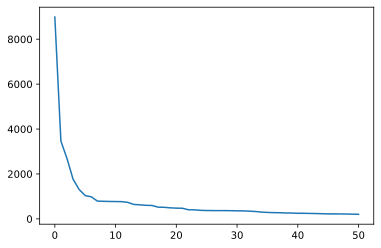

In [8]:
# plot negative outgoing degree of the nodes, in decreasing order
plt.plot(neg_sources[NEG_COUNT][neg_sources[NEG_COUNT] >= 200])

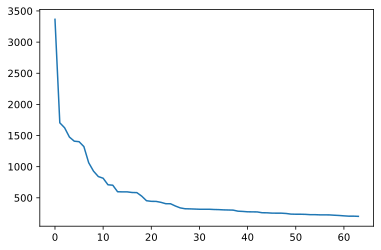

In [9]:
# plot negative incoming degree of nodes, in decreasing order
plt.plot(neg_targets[NEG_COUNT][neg_targets[NEG_COUNT] >= 200])

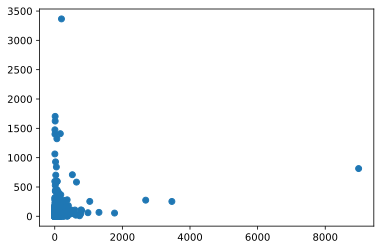

In [10]:
# this is an inner join, but it would make sense to do also an outer join
sources_and_targets = pd.merge(neg_sources, neg_targets,
                               left_on='SOURCE_SUBREDDIT',
                               right_on='TARGET_SUBREDDIT')

SOURCE_NEG_COUNT = NEG_COUNT + '_x'
TARGET_NEG_COUNT = NEG_COUNT + '_y'

# plot the incoming negative degree against the outgoing negative degree
plt.scatter(sources_and_targets[SOURCE_NEG_COUNT], sources_and_targets[TARGET_NEG_COUNT])

As we can see, it seems that there is not a correlation between target and source. In particular, the biggest targets of negative edges are not themselves big sources. This could probably be because different subreddits have different social roles. For example, a subreddit on news (as many top negativity targets are) probably would not be interested in reciprocating the negativity it gets from its readers. It could also be related to the fact that the targets don't necessarily know they are being targeted, since the edges are just links in the source subreddit.

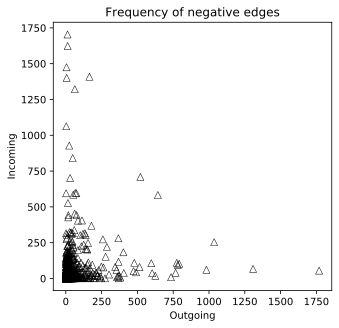

In [11]:
# let's see how it looks when we cut the outliers
small_s_and_t = sources_and_targets[(sources_and_targets[SOURCE_NEG_COUNT] <= 2000)
                                    & (sources_and_targets[TARGET_NEG_COUNT] <= 2000)]

plt.figure(figsize=(5, 5))
plt.gca().set_aspect('equal')
plt.scatter(small_s_and_t[SOURCE_NEG_COUNT], small_s_and_t[TARGET_NEG_COUNT],
            s=50, marker='^', facecolors='none', edgecolors='black',
            linewidths=0.5)
plt.title('Frequency of negative edges')
plt.xlabel('Outgoing')
plt.ylabel('Incoming')
plt.savefig('plots/triangles_up.pdf')

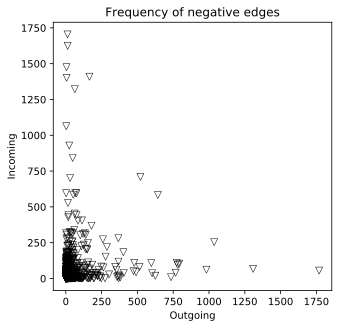

In [12]:
# same but with downwards triangles
plt.figure(figsize=(5, 5))
plt.gca().set_aspect('equal')
plt.scatter(small_s_and_t[SOURCE_NEG_COUNT], small_s_and_t[TARGET_NEG_COUNT],
            s=50, marker='v', facecolors='none', edgecolors='black',
            linewidths=0.5)
plt.title('Frequency of negative edges')
plt.xlabel('Outgoing')
plt.ylabel('Incoming')
plt.savefig('plots/triangles_down.pdf')

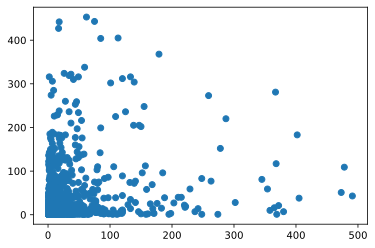

In [13]:
# cut some more
small_s_and_t = sources_and_targets[(sources_and_targets[SOURCE_NEG_COUNT] <= 500)
                                    & (sources_and_targets[TARGET_NEG_COUNT] <= 500)]
plt.scatter(small_s_and_t[SOURCE_NEG_COUNT], small_s_and_t[TARGET_NEG_COUNT])

It surely looks like big targets are not big sources (and vice-versa). But now let's check the percentages of negative edges, instead of their counts.

In [14]:
SOURCE = 'SOURCE_SUBREDDIT'
TARGET = 'TARGET_SUBREDDIT'
all_sources = HL[SOURCE].value_counts()
all_targets = HL[TARGET].value_counts()

perc_neg_sources = neg_sources.set_index(SOURCE, drop=False)
perc_neg_targets = neg_targets.set_index(TARGET, drop=False)

# count of all edges
ALL_COUNT = 'ALL_COUNT'
perc_neg_sources[ALL_COUNT] = all_sources
perc_neg_targets[ALL_COUNT] = all_targets

# percentage of negative edges
PERCENTAGE = 'PERCENTAGE'
perc_neg_sources[PERCENTAGE] = perc_neg_sources[NEG_COUNT] / perc_neg_sources[ALL_COUNT]
perc_neg_targets[PERCENTAGE] = perc_neg_targets[NEG_COUNT] / perc_neg_targets[ALL_COUNT]

# order by percentage (descending)
perc_neg_sources.sort_values(PERCENTAGE, ascending=False, inplace=True)
perc_neg_targets.sort_values(PERCENTAGE, ascending=False, inplace=True)

# the (descending) order of subreddits by percentage
RANK = 'RANK'
perc_neg_sources[RANK] = np.arange(len(perc_neg_sources))
perc_neg_targets[RANK] = np.arange(len(perc_neg_targets))

# to make more reasonable (and readable) plots
perc_neg_sources = perc_neg_sources.set_index(RANK)
perc_neg_targets = perc_neg_targets.set_index(RANK)

# filter out those subreddits with a very little amount of edges
# they would have skewed values for the percentage of negative edges
threshold = 10
cut_perc_neg_sources = perc_neg_sources[perc_neg_sources[ALL_COUNT] >= threshold]

# top nodes, by percentage of negative outgoing edges
cut_perc_neg_sources[:23]

SOURCE_SUBREDDIT  NEG_COUNT  ALL_COUNT  PERCENTAGE
RANK                                                         
1142          shitgnomesays         12         13    0.923077
1143       topcuntsofreddit         23         25    0.920000
1144            theaquapill          9         10    0.900000
1151             randomshit         11         13    0.846154
1156    brockturnerinnocent         12         15    0.800000
1160            bitchimabus          8         10    0.800000
1161      respectfullyyours         12         15    0.800000
1166                sjwnews         96        123    0.780488
1167     deadpoolhatersclub         62         82    0.756098
1180             shitsassay          9         12    0.750000
1192       angryblackladies         78        110    0.709091
1193  incel_because_reasons          7         10    0.700000
1194          wallpaperdump          7         10    0.700000
1195           fuckingsteve          9         13    0.692308
1196              honeyhive         18         26    0.692308
1206             meincanada         10         15    0.666667
1213                 leclub         10         15    0.666667
1231              srstranny          8         12    0.666667
1237         badphilosophy2         12         18    0.666667
1266           ghostsrights         12         18    0.666667
1271          clicksonlinks         16         25    0.640000
1272       shitshitshitpost         14         22    0.636364
1277              gifbattle         17         28    0.607143

In [15]:
# with a higher threshold
threshold = 100
cut_perc_neg_sources = cut_perc_neg_sources[cut_perc_neg_sources[ALL_COUNT] >= threshold]
cut_perc_neg_sources[:23]

SOURCE_SUBREDDIT  NEG_COUNT  ALL_COUNT  PERCENTAGE
RANK                                                        
1166               sjwnews         96        123    0.780488
1192      angryblackladies         78        110    0.709091
1328     publichealthwatch        302        569    0.530756
1985     leftwithsharpedge         59        123    0.479675
1994              amrsucks        221        482    0.458506
2010    metacancersubdrama         56        127    0.440945
2012  harmreductionexperts         54        123    0.439024
2043    againstkarmawhores        369        886    0.416479
2044      shiteuropeanssay        171        415    0.412048
2049           nolibswatch        120        295    0.406780
2109       trueredditdrama        122        306    0.398693
2110             bnestrong        120        302    0.397351
2111                 drama       2690       6784    0.396521
2117            consluting         42        109    0.385321
2127     againstmensrights        278        724    0.383978
2128                  rant         51        133    0.383459
2160     shitsocialismsays         90        245    0.367347
2167              badkarma         61        169    0.360947
2169              frdbroke         77        215    0.358140
2171               worstof        491       1377    0.356572
2172              srssucks        782       2211    0.353686
2181       vegancirclejerk         58        170    0.341176
2182        watchredditdie         65        191    0.340314

In [16]:
# filter out those subreddits with a very little amount of edges
# they would have skewed values for the percentage of negative edges
threshold = 10
cut_perc_neg_targets = perc_neg_targets[perc_neg_targets[ALL_COUNT] >= threshold]

# top nodes, by percentage of negative incoming edges
cut_perc_neg_targets[:23]

TARGET_SUBREDDIT  NEG_COUNT  ALL_COUNT  PERCENTAGE
RANK                                                         
627                     uva          9         12    0.750000
629          torontoanarchy         20         28    0.714286
631               steamship          7         10    0.700000
632   hearthstonecirclejerk         34         49    0.693878
669          biggestproblem         11         17    0.647059
670                abortion         16         25    0.640000
671     chromanauts_eternal          7         11    0.636364
684       theydidthefuckyou          6         10    0.600000
689            shitshitpost         13         23    0.565217
690        outofthemetaloop          6         11    0.545455
691             girlsdoporn          6         11    0.545455
864                     als          6         12    0.500000
1110      leftwithsharpedge         14         29    0.482759
1111           wackytictacs         11         23    0.478261
1112         metametacanada         10         21    0.476190
1113             insertions          9         19    0.473684
1114  thescienceofdeduction          6         13    0.461538
1115      talesfromsecurity          6         13    0.461538
1116               adultery         11         24    0.458333
1117         feminismformen          5         11    0.454545
1118           summerreddit          5         11    0.454545
1119      jesuschristreddit         14         31    0.451613
1120              labsafety          9         20    0.450000

In [17]:
# with a higher threshold
threshold = 100
cut_perc_neg_targets = cut_perc_neg_targets[cut_perc_neg_targets[ALL_COUNT] >= threshold]
cut_perc_neg_targets[:23]

TARGET_SUBREDDIT  NEG_COUNT  ALL_COUNT  PERCENTAGE
RANK                                                        
1121     againstmensrights        152        340    0.447059
1143               worstof         43        106    0.405660
1193           nolibswatch         44        117    0.376068
1234       gender_critical         66        187    0.352941
1238          metanarchism         49        140    0.350000
1245           blackladies        131        381    0.343832
1583       climateskeptics         43        130    0.330769
1584                askmrp         46        140    0.328571
1588                  rage        154        482    0.319502
1589         morbidreality         97        304    0.319079
1595            gamerghazi        304        974    0.312115
1596           gunsarecool         67        216    0.310185
1603        marriedredpill         78        254    0.307087
1605               skeptic         91        300    0.303333
1606       pussypassdenied         61        203    0.300493
1612          ggfreeforall         33        110    0.300000
1622  bestofoutrageculture         59        197    0.299492
1623        livestreamfail         48        161    0.298137
1627              shitpost         67        227    0.295154
1633     bestoflegaladvice         42        143    0.293706
1635            consulting         38        130    0.292308
1641             pussypass         36        124    0.290323
1642              brisbane         76        262    0.290076

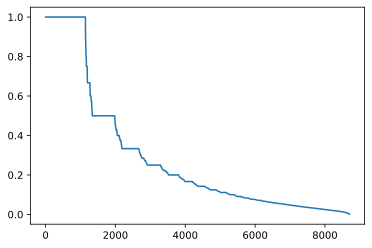

In [18]:
# plot negative outgoing edge percentages of the nodes, in decreasing order
plt.plot(perc_neg_sources[PERCENTAGE])

(array([5.080e+02, 8.970e+02, 8.330e+02, 6.290e+02, 5.610e+02, 3.560e+02,
        3.410e+02, 3.360e+02, 3.160e+02, 4.000e+02, 8.200e+01, 1.310e+02,
        4.160e+02, 7.100e+01, 1.040e+02, 3.300e+01, 5.020e+02, 1.400e+01,
        3.700e+01, 8.100e+01, 8.000e+00, 3.100e+01, 1.700e+01, 9.000e+00,
        6.490e+02, 2.000e+00, 8.000e+00, 4.000e+00, 1.500e+01, 2.900e+01,
        1.000e+00, 6.000e+00, 0.000e+00, 7.400e+01, 4.000e+00, 1.000e+00,
        0.000e+00, 2.500e+01, 0.000e+00, 1.100e+01, 0.000e+00, 4.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.142e+03]),
 array([7.17875090e-04, 2.07035176e-02, 4.06891601e-02, 6.06748026e-02,
        8.06604451e-02, 1.00646088e-01, 1.20631730e-01, 1.40617373e-01,
        1.60603015e-01, 1.80588658e-01, 2.00574300e-01, 2.20559943e-01,
        2.40545585e-01, 2.60531228e-01, 2.80516870e-01, 3.00502513e-01,
        3.20488155e-01, 3.40473798e-01, 3.60459440e-01, 3.80445083e-01,
        4.004307

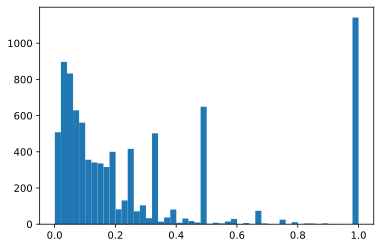

In [19]:
# now as a histogram
plt.hist(perc_neg_sources[PERCENTAGE], bins=50)

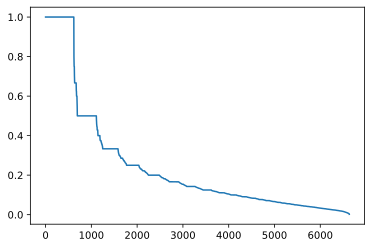

In [20]:
# plot negative incoming edge percentages of the nodes, in decreasing order
plt.plot(perc_neg_targets[PERCENTAGE])

The shapes of the plot for sources and the one for targets look amazingly similar. Probably because of the flat spots for percentages 1, 1/2, 1/3, 1/4 that many small subreddits have.

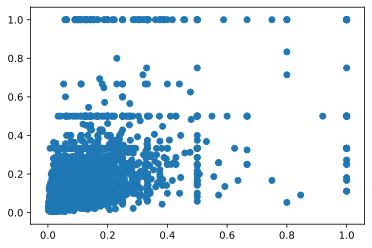

In [21]:
perc_s_and_t = pd.merge(perc_neg_sources, perc_neg_targets,
                        left_on='SOURCE_SUBREDDIT',
                        right_on='TARGET_SUBREDDIT')

SOURCE_PERC = PERCENTAGE + '_x'
TARGET_PERC = PERCENTAGE + '_y'

# plot the incoming negative edge percentage against the outgoing negative edge percentage
plt.scatter(perc_s_and_t[SOURCE_PERC], perc_s_and_t[TARGET_PERC])
# you can see the lines for the nodes that had only a few edges, and one of them negative
# corresponding to the flat spots in the previous plots

The coefficient of determination R^2 of the prediction is 0.5248186551122886


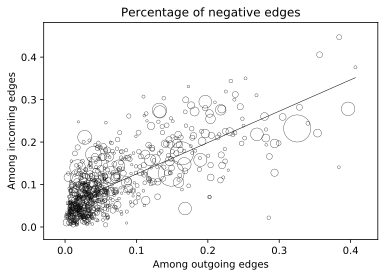

In [22]:
# let's see how it looks when we focus on nodes with higher degree
threshold = 100
small_perc_s_and_t = perc_s_and_t[(perc_s_and_t[ALL_COUNT + '_x'] >= threshold)
                                    & (perc_s_and_t[ALL_COUNT + '_y'] >= threshold)]

model=LinearRegression(fit_intercept=True)
model.fit(small_perc_s_and_t[SOURCE_PERC][:, np.newaxis],
          small_perc_s_and_t[TARGET_PERC][:, np.newaxis])
xfit=np.linspace(small_perc_s_and_t[SOURCE_PERC].min(),
                 small_perc_s_and_t[SOURCE_PERC].max(),100)
yfit=model.predict(xfit[:, np.newaxis])
r_squared = model.score(small_perc_s_and_t[SOURCE_PERC][:, np.newaxis],
                        small_perc_s_and_t[TARGET_PERC][:, np.newaxis])

# plt.figure(figsize=(5, 5))
# plt.gca().set_aspect('equal')
weight = small_perc_s_and_t[ALL_COUNT + '_x'] + small_perc_s_and_t[ALL_COUNT + '_y']
plt.scatter(small_perc_s_and_t[SOURCE_PERC], small_perc_s_and_t[TARGET_PERC],
            s=weight/42, facecolors='none', edgecolors='black',
            linewidths=0.3)
plt.plot(xfit,yfit, color="black", linewidth=0.5)
plt.title('Percentage of negative edges')
plt.xlabel('Among outgoing edges')
plt.ylabel('Among incoming edges')
plt.savefig('plots/blobs_empty.pdf')

print(f'The coefficient of determination R^2 of the prediction is {r_squared}')

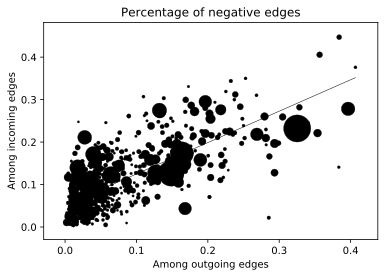

In [23]:
# the same but filled
# plt.figure(figsize=(5, 5))
# plt.gca().set_aspect('equal')
plt.scatter(small_perc_s_and_t[SOURCE_PERC], small_perc_s_and_t[TARGET_PERC],
            s=weight/42, facecolors='black', edgecolors='black',
            linewidths=0.3)
plt.plot(xfit,yfit, color="black", linewidth=0.5)
plt.title('Percentage of negative edges')
plt.xlabel('Among outgoing edges')
plt.ylabel('Among incoming edges')
plt.savefig('plots/blobs_filled.pdf')

So it could be that our previous plot, similar to these but with negative edge count instead of percentage, can be explained by the fact the some subreddits simply have a lot more incoming edges than outgoing edges, and vice versa. For the ones that have more incoming edges, it could be that their links point mostly to other websites (outside of reddit); think about news-related reddits. Let's try to print their edge counts to see if we gain more insight.

In [24]:
PERC_OUT = 'PERCENTAGE_OUT'
PERC_IN = 'PERCENTAGE_IN'

# we have the outgoing/incoming edge counts in perc_neg_sources/perc_neg_targets
out_in_perc = pd.merge(perc_neg_sources, perc_neg_targets, left_on=SOURCE, right_on=TARGET, suffixes=('_OUT', '_IN'))

# Now the columns 'PERCENTAGE_OUT' and 'PERCENTAGE_IN' do not include the values we want;
# they still contain respectively the percentage of negative edges among outgoing edges
# and the percentage of negative edges among incoming edges.
# Let's reassign them to what we need now:
# the percentage of outgoing edges among all incident edges
out_in_perc[PERC_OUT] = (out_in_perc['ALL_COUNT_OUT']
                         / (out_in_perc['ALL_COUNT_OUT'] + out_in_perc['ALL_COUNT_IN']))
# and the percentage of incoming edges among all incident edges
out_in_perc[PERC_IN] = (out_in_perc['ALL_COUNT_IN']
                         / (out_in_perc['ALL_COUNT_OUT'] + out_in_perc['ALL_COUNT_IN']))

# then clean up the data frame a bit
out_in_perc.drop(columns=[TARGET], inplace=True)
out_in_perc.rename(columns={SOURCE: 'SUBREDDIT'}, inplace=True)
out_in_perc.set_index('SUBREDDIT', inplace=True)
    
# let's look first at the top negative sources:
# do they have overall high percentages of outgoing edges?
top_neg_sources = neg_sources[:23][SOURCE]
out_in_perc.reindex(top_neg_sources)

NEG_COUNT_OUT  ALL_COUNT_OUT  PERCENTAGE_OUT  \
SOURCE_SUBREDDIT                                                      
subredditdrama                8987.0        27636.0        0.887390   
bestof                        3464.0        21170.0        0.935525   
drama                         2690.0         6784.0        0.872877   
circlebroke2                  1769.0         6583.0        0.963131   
shitpost                      1308.0         6658.0        0.967030   
shitredditsays                1036.0         7839.0        0.894557   
shitstatistssay                982.0         4504.0        0.953228   
shitamericanssay               792.0         5963.0        0.940091   
srssucks                       782.0         2211.0        0.838771   
circlebroke                    775.0         2640.0        0.826550   
evenwithcontext                  NaN            NaN             NaN   
shitliberalssay                767.0         3765.0        0.959969   
botsrights                     735.0         2314.0        0.979678   
conspiracy                     643.0         3850.0        0.493590   
gamingcirclejerk               625.0         2532.0        0.971977   
fitnesscirclejerk              603.0         3324.0        0.960694   
thebluepill                    597.0         2137.0        0.838697   
the_donald                     521.0         2749.0        0.379906   
topmindsofreddit               515.0         2346.0        0.890661   
worstof                        491.0         1377.0        0.928523   
enoughlibertarianspam          478.0         2072.0        0.810325   
badphilosophy                  473.0         3021.0        0.921037   
hailcorporate                  405.0         5360.0        0.953228   

                       NEG_COUNT_IN  ALL_COUNT_IN  PERCENTAGE_IN  
SOURCE_SUBREDDIT                                                  
subredditdrama                814.0        3507.0       0.112610  
bestof                        253.0        1459.0       0.064475  
drama                         275.0         988.0       0.127123  
circlebroke2                   55.0         252.0       0.036869  
shitpost                       67.0         227.0       0.032970  
shitredditsays                254.0         924.0       0.105443  
shitstatistssay                61.0         221.0       0.046772  
shitamericanssay              103.0         380.0       0.059909  
srssucks                       94.0         425.0       0.161229  
circlebroke                   109.0         554.0       0.173450  
evenwithcontext                 NaN           NaN            NaN  
shitliberalssay                40.0         157.0       0.040031  
botsrights                      9.0          48.0       0.020322  
conspiracy                    583.0        3950.0       0.506410  
gamingcirclejerk               19.0          73.0       0.028023  
fitnesscirclejerk              37.0         136.0       0.039306  
thebluepill                   107.0         411.0       0.161303  
the_donald                    709.0        4487.0       0.620094  
topmindsofreddit               80.0         288.0       0.109339  
worstof                        43.0         106.0       0.071477  
enoughlibertarianspam         109.0         485.0       0.189675  
badphilosophy                  51.0         259.0       0.078963  
hailcorporate                  38.0         263.0       0.046772

It seems that indeed the top sources of negative edges (by count) have overall a lot more outgoing edges than incoming edges. It's interesting that one of these top sources of negative edges is not itself the target of any negative edge. It's the one that got NaN values (because of the way we built this data frame reusing previous ones we already had).

Now let's look at the top targets (by count) and see if they have overall a lot more incoming (than outgoing) edges.

In [25]:
top_neg_targets = neg_targets[:23][TARGET]
out_in_perc.reindex(top_neg_targets)

NEG_COUNT_OUT  ALL_COUNT_OUT  PERCENTAGE_OUT  NEG_COUNT_IN  \
TARGET_SUBREDDIT                                                               
askreddit                   199           1338        0.047854          3366   
worldnews                    12            303        0.029570          1704   
news                         13            473        0.057930          1624   
pics                          5            253        0.019718          1475   
todayilearned               165           1294        0.104204          1409   
videos                        6            341        0.032934          1401   
funny                        63            979        0.083277          1322   
adviceanimals                 3             51        0.009183          1063   
politics                     24            560        0.083908           928   
wtf                          48            403        0.070418           841   
subredditdrama             8987          27636        0.887390           814   
the_donald                  521           2749        0.379906           709   
iama                         30           1187        0.081118           702   
relationships                66            336        0.110236           597   
gifs                          2             45        0.008557           595   
gaming                       74           2072        0.253642           595   
twoxchromosomes              52            257        0.105112           585   
conspiracy                  643           3850        0.493590           583   
tifu                         15            244        0.071137           527   
kotakuinaction               62            323        0.125779           453   
showerthoughts               75            472        0.100984           443   
movies                       18            646        0.142636           442   
technology                   17            486        0.121016           427   

                  ALL_COUNT_IN  PERCENTAGE_IN  
TARGET_SUBREDDIT                               
askreddit                26622       0.952146  
worldnews                 9944       0.970430  
news                      7692       0.942070  
pics                     12578       0.980282  
todayilearned            11124       0.895796  
videos                   10013       0.967066  
funny                    10777       0.916723  
adviceanimals             5503       0.990817  
politics                  6114       0.916092  
wtf                       5320       0.929582  
subredditdrama            3507       0.112610  
the_donald                4487       0.620094  
iama                     13446       0.918882  
relationships             2712       0.889764  
gifs                      5214       0.991443  
gaming                    6097       0.746358  
twoxchromosomes           2188       0.894888  
conspiracy                3950       0.506410  
tifu                      3186       0.928863  
kotakuinaction            2245       0.874221  
showerthoughts            4202       0.899016  
movies                    3883       0.857364  
technology                3530       0.878984

Yep, the top targets of negative edges (by count) indeed have overall more incoming edges than outgoing edges, with only one expection (subredditdrama).

Now the plots with triangles make much more sense.

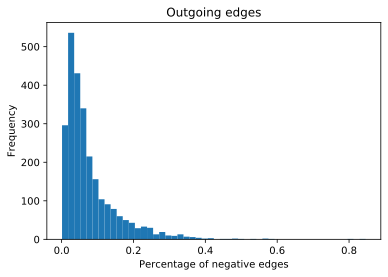

In [26]:
# let's go back to the percentages; plot histograms for the distributions of the percentages of negative edges
# for outgoing and incoming edges, and for nodes with in-degree and out-degree at least 10
threshold = 10
small_perc_s_and_t = perc_s_and_t[(perc_s_and_t[ALL_COUNT + '_x'] >= threshold)
                                    & (perc_s_and_t[ALL_COUNT + '_y'] >= threshold)]
plt.hist(small_perc_s_and_t[SOURCE_PERC], bins=50)
plt.title('Outgoing edges')
plt.xlabel('Percentage of negative edges')
plt.ylabel('Frequency')
plt.savefig('plots/hist_out.pdf')

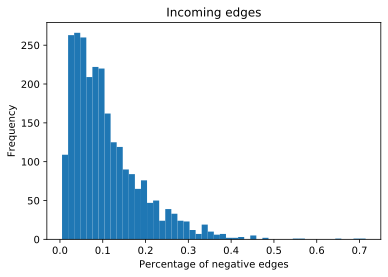

In [27]:
plt.hist(small_perc_s_and_t[TARGET_PERC], bins=50)
plt.title('Incoming edges')
plt.xlabel('Percentage of negative edges')
plt.ylabel('Frequency')
plt.savefig('plots/hist_in.pdf')

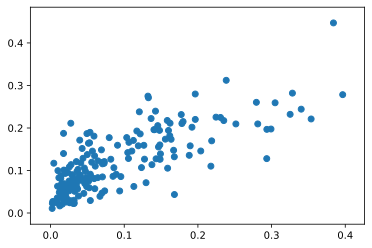

In [28]:
# even higher degree
threshold = 300
small_perc_s_and_t = perc_s_and_t[(perc_s_and_t[ALL_COUNT + '_x'] >= threshold)
                                    & (perc_s_and_t[ALL_COUNT + '_y'] >= threshold)]
plt.scatter(small_perc_s_and_t[SOURCE_PERC], small_perc_s_and_t[TARGET_PERC])

Contrary to what appeared in the plot with edge counts, it would seem that there is indeed a positive correlation between outgoing negativity and incoming negativity.

Moving on to a related question, let's see how incoming (and outcoming) negative edge count grows as total edge count grows.

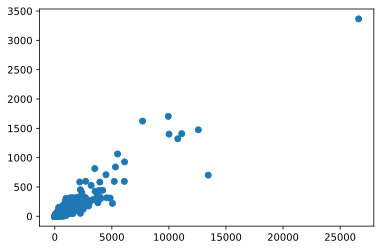

In [29]:
plt.scatter(perc_neg_targets[ALL_COUNT], perc_neg_targets[NEG_COUNT])

For targets, there seem to be more or less a positive (linear?) correlation between total incoming edge count and incoming negative edge count. This intuitively makes sense, because node with more edges overall probably have also more negative edges. Let's see if it still looks linear when we leave out the biggest targets.

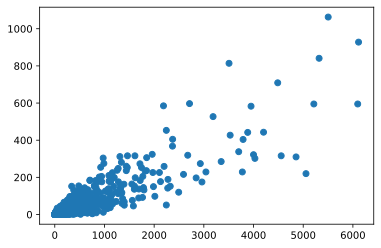

In [30]:
small_targets = perc_neg_targets[perc_neg_targets[ALL_COUNT] <= 7500]
plt.scatter(small_targets[ALL_COUNT], small_targets[NEG_COUNT])

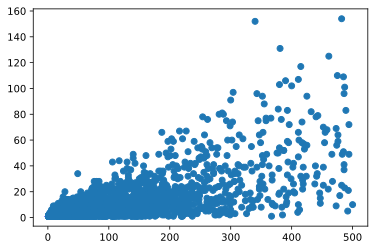

In [31]:
# let's try even smaller ones
small_targets = perc_neg_targets[perc_neg_targets[ALL_COUNT] <= 500]
plt.scatter(small_targets[ALL_COUNT], small_targets[NEG_COUNT])

It still looks like they're correlated. Now let's see if the same holds for sources.

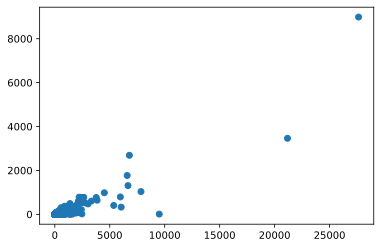

In [32]:
plt.scatter(perc_neg_sources[ALL_COUNT], perc_neg_sources[NEG_COUNT])

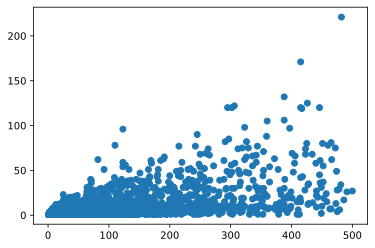

In [33]:
# leave out the bigger sources
small_sources = perc_neg_sources[perc_neg_sources[ALL_COUNT] <= 500]
plt.scatter(small_sources[ALL_COUNT], small_sources[NEG_COUNT])

It is indeed quite similar to the plots we got for targets.

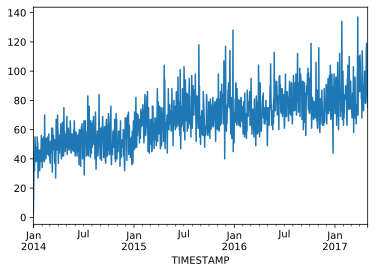

In [34]:
# convert NEG and POS to time series
POS_TS = POS.copy()
NEG_TS = NEG.copy()

POS_TS['TIMESTAMP'] = pd.to_datetime(POS_TS['TIMESTAMP'])
POS_TS_COUNTS = POS_TS.groupby(POS_TS['TIMESTAMP'].dt.floor('d')).size()
POS_TS_COUNTS.rename('POSITIVE_EDGE_COUNT', inplace=True)
NEG_TS['TIMESTAMP'] = pd.to_datetime(NEG_TS['TIMESTAMP'])
NEG_TS_COUNTS = NEG_TS.groupby(NEG_TS['TIMESTAMP'].dt.floor('d')).size()
NEG_TS_COUNTS.rename('NEGATIVE_EDGE_COUNT', inplace=True)

NEG_TS_COUNTS.plot()
# overall traffic is increasing (compare to analogous percentage plot)

In [35]:
# what are the days with the highest negative edge count?
NEG_TS_COUNTS.sort_values(ascending=False)[:7]

TIMESTAMP
2017-03-25    137
2017-01-26    134
2015-12-27    128
2017-04-26    119
2016-10-06    119
2015-08-25    118
2015-11-30    117
Name: NEGATIVE_EDGE_COUNT, dtype: int64

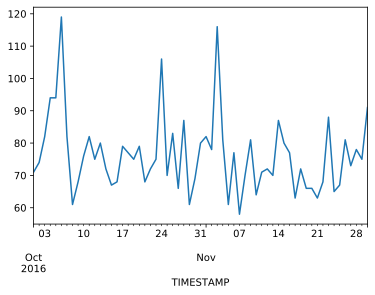

In [36]:
# October and November 2016 (US presidential election was on 8th November)
NEG_TS_COUNTS['2016-10-01' : '2016-11-30'].plot()

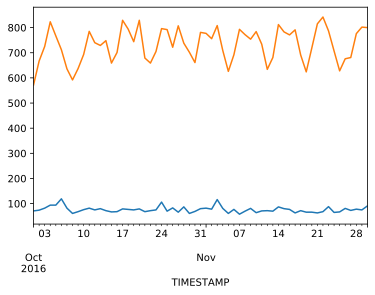

In [37]:
# plot together negative and positive edges over the same period
NEG_TS_COUNTS['2016-10-01' : '2016-11-30'].plot()
POS_TS_COUNTS['2016-10-01' : '2016-11-30'].plot()

There seem to be some clear patterns for positive edges, probably a decrease in weekends? Less clear patterns in negative edges, maybe because there's less of them overall. Interesting question: are there bursts of negative edges from one subreddit to another in a short time span?

Now let's try plotting the percentages of negative edges as a time series, once again one value per day.

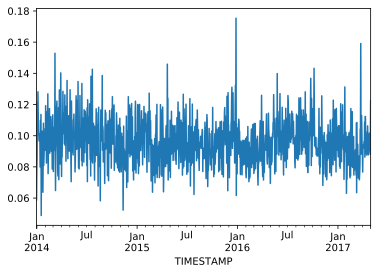

In [38]:
PERC_TS = pd.merge(POS_TS_COUNTS, NEG_TS_COUNTS, left_index=True, right_index=True)
percentage_ts = PERC_TS.NEGATIVE_EDGE_COUNT / (PERC_TS.NEGATIVE_EDGE_COUNT
                                            + PERC_TS.POSITIVE_EDGE_COUNT)
PERC_TS[PERCENTAGE] = percentage_ts
percentage_ts.plot()

In [39]:
# the days with the highest percentages of negative edges
percentage_ts.sort_values(ascending=False).head()
# they seem quite random

TIMESTAMP
2015-12-27    0.175342
2017-03-25    0.159117
2014-03-08    0.152882
2015-04-21    0.145863
2016-10-06    0.143201
dtype: float64

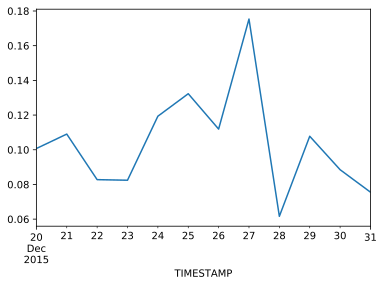

In [40]:
# focus on the periods around some of the peaks
percentage_ts['2015-12-20' : '2015-12-31'].plot()

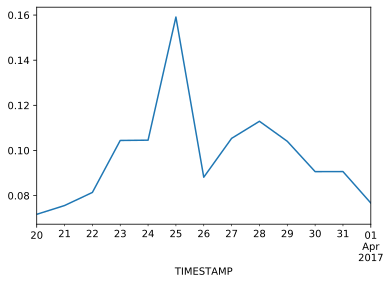

In [41]:
percentage_ts['2017-03-20' : '2017-04-01'].plot()

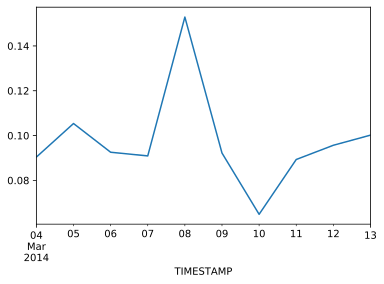

In [42]:
percentage_ts['2014-03-04' : '2014-03-13'].plot()

Lastly, an example of how to import a pandas data frame representing an edgelist (like the ones we've been working with in this notebook) into networkx, and from there into gephi.

In [43]:
mask = (NEG['TIMESTAMP'] >= '2016-10-01') & (NEG['TIMESTAMP'] <= '2016-11-30')
# note: I didn't use NEG_TS because it told me that the attribute type Timestamp
# is not supported... still this can work as time series in gephi
# note: it's necessary to tell nx that it is a MultiDiGraph
ELECTION_TS_G = nx.from_pandas_edgelist(NEG[mask], SOURCE, TARGET,
                                        edge_attr=True, create_using=nx.MultiDiGraph)
nx.write_gexf(ELECTION_TS_G, 'ELECTION_TS.gexf')